# Menentukan Pertanyaan Bisnis

1. Skill apa yang paling umum dibutuhkan dalam tiap job function berdasarkan analisis job description?
   - Memberikan insight bagi pencari kerja untuk mengetahui skill yang meningkatkan peluang mendapat pekerjaan yang sesuai.
   - Membantu pelamar mengetahui posisi mereka dibanding pasar tenaga kerja.
2. Bagaimana karakteristik lowongan berdasarkan education level, career level dan experience level di berbagai industri?
   - Membantu kandidat memahami industri mana yang banyak membuka peluang di level karir tertentu.
   - Berguna untuk perusahaan dalam kompetisi talent acquisition dan strategi hiring.

# Import Semua Packages/Library yang Digunakan

In [2]:
import re
import ast
import string
import spacy
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from pyvis.network import Network
from skillNer.skill_extractor_class import SkillExtractor
from spacy.matcher import PhraseMatcher
from skillNer.general_params import SKILL_DB
from tqdm import tqdm
from collections import Counter
from wordcloud import WordCloud

# Data Wrangling

## Gathering Data

In [2]:
df = pd.read_csv("../../data/all.csv", delimiter="|")
df.head()

,id,job_title,location,salary_currency,career_level,experience_level,education_level,employment_type,job_function,job_benefits,company_process_time,company_size,company_industry,job_description,salary
0,1,Facility Maintenance & Smart Warehouse Manager,Bandung,IDR,Manajer/Asisten Manajer,5 tahun,"Sertifikat Professional, D3 (Diploma), D4 (Dip...",Penuh Waktu,"Manufaktur,Pemeliharaan",NaN,NaN,NaN,NaN,Deskripsi PekerjaanRequirements :D3/SI from re...,NaN
1,2,Procurement Department Head,Jakarta Raya,IDR,Manajer/Asisten Manajer,5 tahun,"Sarjana (S1), Diploma Pascasarjana, Gelar Prof...",Penuh Waktu,"Manufaktur,Pembelian/Manajemen Material",NaN,25 days,51 - 200 pekerja,Manajemen/Konsulting HR,Job Role: 1. Responsible for material availabi...,NaN
2,3,SALES ADMIN,Jakarta Barat,IDR,Supervisor/Koordinator,4 tahun,Sarjana (S1),Penuh Waktu,"Penjualan / Pemasaran,Penjualan Ritel","Waktu regular, Senin - Jumat;Bisnis (contoh: K...",30 days,51 - 200 pekerja,Umum & Grosir,Internal Sales & AdminJob Description :We are ...,NaN
3,4,City Operation Lead Shopee Express (Cirebon),Cirebon,IDR,Supervisor/Koordinator,5 tahun,"Sarjana (S1), Diploma Pascasarjana, Gelar Prof...",Penuh Waktu,"Pelayanan,Logistik/Rantai Pasokan","Tip;Waktu regular, Senin - Jumat;Kasual (conto...",21 days,2001 - 5000 pekerja,Retail/Merchandise,Job Description:Responsible for HSE implementa...,NaN
4,5,Japanese Interpreter,Bekasi,IDR,Pegawai (non-manajemen & non-supervisor),2 tahun,"Sertifikat Professional, D3 (Diploma), D4 (Dip...",Penuh Waktu,"Lainnya,Jurnalis/Editor",NaN,23 days,201 - 500 pekerja,Manajemen/Konsulting HR,Overview: Our clients is manufacture for autom...,NaN


Merujuk dari dokumentasi datasetnya, berikut ini merupakan penjelasan untuk setiap kolom yang ada:

- job_title = nama pekerjaan
- location = lokasi perusahaan
- salary_currency = mata uang yang digunakan untuk gaji
- career_level = level karir
- experience_level = level pengalaman yang diharuskan untuk pelamar
- education_level = strata pendidikan yang diharuskan untuk pelamar
- employment_type = full-time, part-time, atau internship
- job_function = kategori pekerjaan
- job_benefits = benefit yang diberikan oleh perusahaan
- company_process_time = rata-rata waktu respon perusahaan
- company_size = jumlah karyawan
- company_industry = sektor industri dari perusahaan
- job_description = deskripsi pekerjaan
- salary = gaji yang ditawarkan perusahaan

## Assessing Data

#### Menilai data df

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34746 entries, 0 to 34745
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34746 non-null  int64  
 1   job_title             34746 non-null  object 
 2   location              34746 non-null  object 
 3   salary_currency       34742 non-null  object 
 4   career_level          34746 non-null  object 
 5   experience_level      30205 non-null  object 
 6   education_level       34746 non-null  object 
 7   employment_type       33402 non-null  object 
 8   job_function          34746 non-null  object 
 9   job_benefits          27330 non-null  object 
 10  company_process_time  24555 non-null  object 
 11  company_size          29103 non-null  object 
 12  company_industry      33132 non-null  object 
 13  job_description       34745 non-null  object 
 14  salary                9352 non-null   float64
dtypes: float64(1), int6

Dataframe `df` memiliki 34.746 entri dan memiliki 14 kolom dengan kolom `salary_currency`, `experience_level`, `employment_type`, `job_benefits`, `company_process_time`, `company_size`, `company_industry`, `job_description`, `salary` memiliki data yang hilang. Sebagian besar kolom bertipe object dan hanya kolom `id` yang bertipe `int64` serta kolom `salary` bertipe `float64`.

#### Pemeriksaan parameter statistik

Selanjutnya, dilakukan pemeriksaan ringkasan parameter statistik seperti `count`, `mean`, `std`, `min`, dan `max`untuk kolom `id` dan `salary` yang bertipe numerik.

In [4]:
df.describe()

,id,salary
count,34746.000000,9.352000e+03
mean,17373.500000,7.358879e+06
std,10030.450563,2.148128e+07
min,1.000000,1.000000e+01
25%,8687.250000,4.250000e+06
50%,17373.500000,5.500000e+06
75%,26059.750000,8.000000e+06
max,34746.000000,2.000000e+09


Kolom `id` memiliki `count` sebesar 34.746 yang nilainya sama dengan jumlah baris, artinya tidak ada id yang hilang.

Kolom `salary` memiliki `count` sebesar 9.352 yang artinya hanya 27% dari keseluruhan data yang memiliki gaji, hal ini mengindikasikan banyak missing values. Untuk `mean` dari kolom `salary` sendiri sekitar 7.3 juta. Standar deviasi dari kolom `salary` sebesar 21.48 juta yang mana ini sangat besar menandakan ada outlier besar di dalam data. Nilai minimum gaji adalah 10, kemungkinan karena error input. Adapun untuk gaji berada di rentang 4-8 juta yang mana hal ini terlihat konsisten. Terakhir ada nilai `max` sebesar 2 miliar yang menunjukkan adanya outlier ekstrem.

## Data Cleaning

#### Pemeriksaan duplikasi

Langkah berikut ini untuk melihat jumlah data duplikat yang terdapat di dataframe

In [5]:
print("Jumlah data duplikat dari df:", df.duplicated().sum())

Jumlah data duplikat dari df: 0


Tidak ditemukan adanya duplikat di dataframe `df`.

#### Menangani missing values

Langkah berikut ini untuk melihat jumlah missing values yang terdapat di dataframe

In [6]:
df_clean = df.copy()
df_clean.isnull().sum()

id                          0
job_title                   0
location                    0
salary_currency             4
career_level                0
experience_level         4541
education_level             0
employment_type          1344
job_function                0
job_benefits             7416
company_process_time    10191
company_size             5643
company_industry         1614
job_description             1
salary                  25394
dtype: int64

Selanjutnya dilakukan penanganan untuk kolom yang mempunyai missing values.

In [7]:
df_clean = df_clean.dropna()
df_clean.isnull().sum()

id                      0
job_title               0
location                0
salary_currency         0
career_level            0
experience_level        0
education_level         0
employment_type         0
job_function            0
job_benefits            0
company_process_time    0
company_size            0
company_industry        0
job_description         0
salary                  0
dtype: int64

Mengecek informasi umum dataframe setelah dilakukan penanganan missing values

In [8]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5044 entries, 9 to 34745
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5044 non-null   int64  
 1   job_title             5044 non-null   object 
 2   location              5044 non-null   object 
 3   salary_currency       5044 non-null   object 
 4   career_level          5044 non-null   object 
 5   experience_level      5044 non-null   object 
 6   education_level       5044 non-null   object 
 7   employment_type       5044 non-null   object 
 8   job_function          5044 non-null   object 
 9   job_benefits          5044 non-null   object 
 10  company_process_time  5044 non-null   object 
 11  company_size          5044 non-null   object 
 12  company_industry      5044 non-null   object 
 13  job_description       5044 non-null   object 
 14  salary                5044 non-null   float64
dtypes: float64(1), int64(1), 

#### Cleaning `job_description` text

Langkah berikut ini untuk membersihkan kolom `job_description`.

In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\w*\d\w*', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(' +', ' ', text)
    # text = remove_stopwords(text)
    # text = lemmatize(text)
    return text

df_clean['job_description_cleaned'] = df_clean['job_description'].apply(clean_text)

In [12]:
df_clean.head()

,id,job_title,location,salary_currency,career_level,experience_level,education_level,employment_type,job_function,job_benefits,company_process_time,company_size,company_industry,job_description,salary,job_description_cleaned
9,10,Tax Supervisor,Banten,IDR,Supervisor/Koordinator,3 tahun,"Sertifikat Professional, D3 (Diploma), D4 (Dip...",Penuh Waktu,"Akuntansi / Keuangan,Audit & Pajak","Tip;Asuransi kesehatan;Waktu regular, Senin - ...",22 days,51 - 200 pekerja,Konstruksi/Bangunan/Teknik,ResponsibilitiesPrepare corporate income tax (...,8000000.0,responsibilitiesprepare corporate income tax c...
22,23,Senior Staff Purchasing,Surabaya,IDR,Pegawai (non-manajemen & non-supervisor),2 tahun,"Sertifikat Professional, D3 (Diploma), D4 (Dip...",Penuh Waktu,"Manufaktur,Pembelian/Manajemen Material",Asuransi kesehatan;Jam Bekerja yang Panjang;Bi...,29 days,1- 50 pekerja,Elektrikal & Elektronik,Deskripsi Pekerjaan:Mampu melakukan rencana pe...,5250000.0,deskripsi pekerjaan mampu melakukan rencana pe...
26,27,MARKETING COMMUNICATION & CHANNEL MANAGER,Jakarta Pusat,IDR,Manajer/Asisten Manajer,2 tahun,Tidak terspesifikasi,Penuh Waktu,"Penjualan / Pemasaran,Pemasaran/Pengembangan B...",Asuransi Gigi;Asuransi kesehatan;Parkir;Waktu ...,29 days,51 - 200 pekerja,"Konsultasi (IT, Ilmu Pengetahuan, Teknis & Tek...","SCOPE OF ROLE :To plan, develop, implement and...",15000000.0,scope of role to plan develop implement and me...
31,32,PPIC,Tangerang,IDR,Manajer/Asisten Manajer,5 tahun,Sarjana (S1),Penuh Waktu,"Manufaktur,Manufaktur","Asuransi kesehatan;Waktu regular, Senin - Juma...",21 days,201 - 500 pekerja,Manufaktur/Produksi,Tanggung Jawab:Membuat perencanaan produksi be...,6600000.0,tanggung jawab membuat perencanaan produksi be...
34,35,C# Advanced/Senior Developer,Jakarta Timur,IDR,Supervisor/Koordinator,2 tahun,"SMA, SMU/SMK/STM, Sertifikat Professional, D3 ...",Penuh Waktu,"Komputer/Teknologi Informasi,IT-Perangkat Lunak","Tip;Asuransi kesehatan;Waktu regular, Senin - ...",5 days,1- 50 pekerja,Komputer/Teknik Informatika (Perangkat Lunak),Kualifikasi:Kandidat harus memiliki setidaknya...,9500000.0,kualifikasi kandidat harus memiliki setidaknya...


#### Ekstraksi skill dari kolom `job_description`

Langkah ini untuk mengekstrak skill-skill yang ada dari kolom `job_description`. Ekstraksi menggunakan library `SkillNER` [(Dokumentasi)](https://github.com/AnasAito/SkillNER).

In [15]:
nlp = spacy.load("en_core_web_lg")

skill_extractor = SkillExtractor(
    nlp,
    SKILL_DB,
    PhraseMatcher
)

def extract_doc_node_values(annotation_result):
    if not isinstance(annotation_result, dict) or 'results' not in annotation_result:
        return []

    doc_node_values = []
    results = annotation_result['results']

    if 'full_matches' in results:
        for match in results['full_matches']:
            doc_node_values.append(match['doc_node_value'])

    if 'ngram_scored' in results:
        for match in results['ngram_scored']:
            doc_node_values.append(match['doc_node_value'])

    return doc_node_values

loading full_matcher ...
loading abv_matcher ...
loading full_uni_matcher ...
loading low_form_matcher ...
loading token_matcher ...


In [17]:
annotations = []
for idx, text in tqdm(enumerate(df_clean['job_description_cleaned'].astype(str)), 
                       total=len(df_clean),
                       desc="Extracting skills"):
    try:
        ann = skill_extractor.annotate(text)
    except Exception as e:
        print(f"[SKIPPED] Index {idx} | Error: {e} | Text: {text[:80]}...")
        ann = None  # Supaya aman
    annotations.append(ann)

df_clean['annotations'] = annotations

df_clean['skills'] = df_clean['annotations'].apply(
    lambda x: extract_doc_node_values(x) if isinstance(x, dict) else []
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skillNer/utils.py:99: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  vec_similarity = token1.similarity(token2)
Extracting skills:  38%|████████████████████████████▎                                             | 1934/5044 [11:22<08:17,  6.26it/s]

[SKIPPED] Index 1932 | Error: list index out of range | Text: requirement wajib memakai seragam rok proven years graphic designing experience ...



xtracting skills: 100%|██████████████████████████████████████████████████████████████████████████| 5044/5044 [29:41<00:00,  2.83it/s]

#### Membersihkan noise di kolom `skills`

Langkah ini untuk membersihkan hasil ekstraksi dari tahapan sebelumnya.

In [23]:
# 1. Memastikan kolom skills jadi list
df_clean['skills'] = df_clean['skills'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# 2. Noise words
noise_words = {'job description', 'dari', 'akan', 'ada', 'hal', 'www', 'target','dll','ar','b','e','itu'}

# 3. Cleaning skills
def clean_skills(skills):
    cleaned = []
    for s in skills:
        s = s.lower().strip()

        # Menghapus kata duplikat: "data data" → "data"
        s = re.sub(r'\b(\w+)\s+\1\b', r'\1', s)

        # Skip noise
        if s in noise_words:
            continue

        cleaned.append(s)

    # Menghapus duplikat tapi urutan tetap
    return list(dict.fromkeys(cleaned))

df_clean['skills'] = df_clean['skills'].apply(clean_skills)
df_clean = df_clean[df_clean['skills'].apply(len) > 3]  # Mengambil data dengan skills lebih dari 3

#### Normalisasi `career_level`

In [5]:
print(f'Career Level: {df_clean['career_level'].unique()}')
print(f'Jumlah records Career Level: {df_clean['career_level'].nunique()}')

Career Level: ['Supervisor/Koordinator' 'Manajer/Asisten Manajer'
 'Pegawai (non-manajemen & non-supervisor)'
 'Lulusan baru/Pengalaman kerja kurang dari 1 tahun'
 'CEO/GM/Direktur/Manajer Senior']
Jumlah records Career Level: 5


In [6]:
def normalize_career_level(text):
    text = text.lower()

    if "pegawai" in text:
        return "Staff"
    elif "koordinator" in text:
        return "Supervisor"
    elif "lulusan baru" in text:
        return "Fresh Graduate"
    elif "asisten manajer" in text:
        return "Manajer"
    else:
        return "Executive"

df_clean["career_level_norm"] = df_clean["career_level"].apply(normalize_career_level)

#### Normalisasi `experience_level`

In [14]:
def extract_experience_level(text):
    match = re.search(r'\d+', str(text))
    if match:
        return int(match.group())

def experience_bucket(years):
    if years <= 1:
        return "Entry"
    elif 2 <= years <= 4:
        return "Middle"
    else:
        return "Senior"

df_clean["experience_years"] = df_clean["experience_level"].apply(extract_experience_level)
df_clean["experience_bucket"] = df_clean["experience_years"].apply(experience_bucket)
df_clean[["experience_level", "experience_years", "experience_bucket"]]

,experience_level,experience_years,experience_bucket
0,3 tahun,3,Middle
1,2 tahun,2,Middle
2,5 tahun,5,Senior
3,2 tahun,2,Middle
4,1 tahun,1,Entry
...,...,...,...
2916,4 tahun,4,Middle
2917,1 tahun,1,Entry
2918,2 tahun,2,Middle
2919,1 tahun,1,Entry


#### Normalisasi `education_level`

In [9]:
edu_rank = {
    "sma": 1, "smu": 1, "smk": 1, "stm": 1,
    "sertifikat professional": 2, "sertifikat": 2,
    "d3": 3,
    "d4": 4,
    "sarjana (s1)": 5, "s1": 5,
    "diploma pascasarjana": 6, "gelar professional": 6,
    "magister (s2)": 7, "s2": 7,
    "doktor (s3)": 8, "s3": 8
}

def normalize_education_level(text):
    text = text.lower()

    found_levels = []

    for key, rank in edu_rank.items():
        if key in text:  # kalau ada di string
            found_levels.append((key, rank))

    if not found_levels:
        return "Unknown"

    highest = max(found_levels, key=lambda x: x[1])[0]

    if highest in ["sma", "smu", "smk", "stm"]:
        return "SMA/SMK"
    elif highest.startswith("sertifikat"):
        return "Sertifikat"
    elif highest == "d3":
        return "D3"
    elif highest == "d4":
        return "D4"
    elif highest in ["sarjana (s1)", "s1"]:
        return "S1"
    elif highest in ["diploma pascasarjana", "gelar professional"]:
        return "Pra-S2"
    elif highest in ["magister (s2)", "s2"]:
        return "S2"
    elif highest in ["doktor (s3)", "s3"]:
        return "S3"

    return "Unknown"

In [29]:
df_clean['education_level_norm'] = df_clean['education_level'].apply(normalize_education_level)
df_clean[["education_level_norm", "education_level"]]

,education_level_norm,education_level
0,S1,"Sertifikat Professional, D3 (Diploma), D4 (Dip..."
1,Unknown,Tidak terspesifikasi
2,S1,Sarjana (S1)
3,S1,"SMA, SMU/SMK/STM, Sertifikat Professional, D3 ..."
4,S2,"Sarjana (S1), Diploma Pascasarjana, Gelar Prof..."
...,...,...
2916,S1,Sarjana (S1)
2917,S1,Sarjana (S1)
2918,S2,"Sertifikat Professional, D3 (Diploma), D4 (Dip..."
2919,S1,"SMA, SMU/SMK/STM, Sertifikat Professional, D3 ..."


#### Menyimpan dataframe

In [31]:
os.makedirs("export", exist_ok=True)

df_clean.to_csv(
    "export/final_data.csv",
    index=False
)

# Visualization & Explanatory Analysis

In [3]:
final_df = pd.read_csv("export/final_data.csv")
final_df.head(10)

,id,job_title,location,salary_currency,career_level,experience_level,education_level,employment_type,job_function,job_benefits,...,company_industry,job_description,salary,job_description_cleaned,annotations,skills,career_level_norm,experience_years,experience_bucket,education_level_norm
0,10,Tax Supervisor,Banten,IDR,Supervisor/Koordinator,3 tahun,"Sertifikat Professional, D3 (Diploma), D4 (Dip...",Penuh Waktu,"Akuntansi / Keuangan,Audit & Pajak","Tip;Asuransi kesehatan;Waktu regular, Senin - ...",...,Konstruksi/Bangunan/Teknik,ResponsibilitiesPrepare corporate income tax (...,8000000.0,responsibilitiesprepare corporate income tax c...,{'text': 'responsibilitiesprepare corporate in...,"['income tax', 'tax compliance', 'digital elec...",Supervisor,3,Middle,S1
1,27,MARKETING COMMUNICATION & CHANNEL MANAGER,Jakarta Pusat,IDR,Manajer/Asisten Manajer,2 tahun,Tidak terspesifikasi,Penuh Waktu,"Penjualan / Pemasaran,Pemasaran/Pengembangan B...",Asuransi Gigi;Asuransi kesehatan;Parkir;Waktu ...,...,"Konsultasi (IT, Ilmu Pengetahuan, Teknis & Tek...","SCOPE OF ROLE :To plan, develop, implement and...",15000000.0,scope of role to plan develop implement and me...,{'text': 'scope of role to plan develop implem...,"['marketing communication', 'strategic communi...",Manajer,2,Middle,Unknown
2,32,PPIC,Tangerang,IDR,Manajer/Asisten Manajer,5 tahun,Sarjana (S1),Penuh Waktu,"Manufaktur,Manufaktur","Asuransi kesehatan;Waktu regular, Senin - Juma...",...,Manufaktur/Produksi,Tanggung Jawab:Membuat perencanaan produksi be...,6600000.0,tanggung jawab membuat perencanaan produksi be...,{'text': 'tanggung jawab membuat perencanaan p...,"['warehouse management', 'inventory control', ...",Manajer,5,Senior,S1
3,35,C# Advanced/Senior Developer,Jakarta Timur,IDR,Supervisor/Koordinator,2 tahun,"SMA, SMU/SMK/STM, Sertifikat Professional, D3 ...",Penuh Waktu,"Komputer/Teknologi Informasi,IT-Perangkat Lunak","Tip;Asuransi kesehatan;Waktu regular, Senin - ...",...,Komputer/Teknik Informatika (Perangkat Lunak),Kualifikasi:Kandidat harus memiliki setidaknya...,9500000.0,kualifikasi kandidat harus memiliki setidaknya...,{'text': 'kualifikasi kandidat harus memiliki ...,"['asp net', 'object orient programming', 'c', ...",Supervisor,2,Middle,S1
4,38,IT Software Developer Staff,Jakarta Barat,IDR,Pegawai (non-manajemen & non-supervisor),1 tahun,"Sarjana (S1), Diploma Pascasarjana, Gelar Prof...",Penuh Waktu,"Komputer/Teknologi Informasi,IT-Perangkat Lunak",Kasual (contoh: Kaos);Senin - Jum'at (HO) Seni...,...,Industri Berat/Mesin/Peralatan,Bachelor’s degree of Information Technology or...,6800000.0,bachelor’s degree of information technology or...,{'text': 'bachelor’s degree of information tec...,"['information technology', 'restful api', 'spr...",Staff,1,Entry,S2
5,41,Backend Developer,Jakarta Raya,IDR,Pegawai (non-manajemen & non-supervisor),1 tahun,"SMA, SMU/SMK/STM, Sertifikat Professional, D3 ...",Penuh Waktu,"Komputer/Teknologi Informasi,IT-Perangkat Lunak","Waktu regular, Senin - Jumat;Kasual (contoh: K...",...,Komputer/Teknik Informatika (Perangkat Lunak),Responsibilities:Your duties will include (but...,5500000.0,responsibilities your duties will include but ...,{'text': 'responsibilities your duties will in...,"['operating system', 'asp net', 'software as a...",Staff,1,Entry,S1
6,92,DISTRIBUTION CENTER MANAGER,Jawa Timur,IDR,Manajer/Asisten Manajer,3 tahun,Sarjana (S1),Penuh Waktu,"Pelayanan,Logistik/Rantai Pasokan","Asuransi kesehatan;Parkir;Waktu regular, Senin...",...,Makanan & Minuman/Katering/Restoran,Job Description :Responsible for the whole war...,22500000.0,job description responsible for the whole ware...,{'text': 'job description responsible for the ...,"['operation management', 'management process',...",Manajer,3,Middle,S1
7,130,Senior Infosec Engineer,Jakarta Selatan,IDR,Supervisor/Koordinator,4 tahun,"SMA, SMU/SMK/STM, Sarjana (S1)",Penuh Waktu,"Komputer/Teknologi Informasi,IT-Perangkat Lunak",Asuransi Gigi;Asuransi kesehatan;Waktu regular...,..

## Pertanyaan 1

#### Histogram panjang job_description

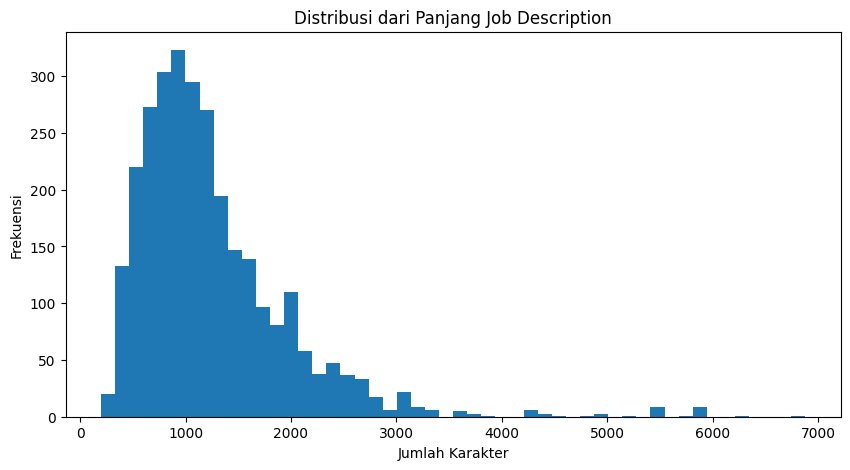

In [4]:
final_df["desc_length"] = final_df["job_description"].astype(str).apply(len)

plt.figure(figsize=(10,5))
plt.hist(final_df["desc_length"], bins=50)
plt.title("Distribusi dari Panjang Job Description")
plt.xlabel("Jumlah Karakter")
plt.ylabel("Frekuensi")
plt.show()

Mayoritas `job_description` berada pada rentang 700–1300 karakter, menunjukkan bahwa postingan lowongan umumnya cukup informatif untuk ekstraksi skill. Distribusi miring ke kanan menandakan adanya sebagian kecil deskripsi yang sangat panjang, namun tidak mengganggu mayoritas data. Secara keseluruhan, kualitas panjang teks stabil dan siap digunakan untuk pipeline NLP.

#### Barplot — 20 Biggest Skills

In [5]:
final_df["skills"] = final_df["skills"].apply(ast.literal_eval)
all_skills = [skill for sublist in final_df["skills"] for skill in sublist]
skill_counts = Counter(all_skills)
top_20_skills = pd.DataFrame(skill_counts.most_common(20), columns=["skill", "count"])

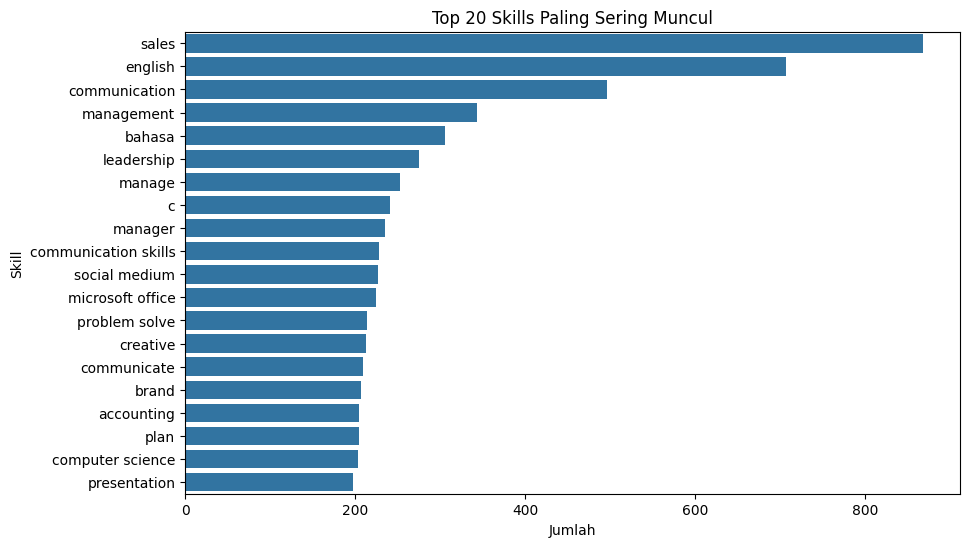

In [6]:
plt.figure(figsize=(10,6))
sns.barplot(data=top_20_skills, x="count", y="skill")
plt.title("Top 20 Skills Paling Sering Muncul")
plt.xlabel("Jumlah")
plt.ylabel("Skill")
plt.show()

Berdasarkan visualisasi tersebut, diperoleh beberapa temuan penting:
- Skill “sales” merupakan skill yang paling dominan di dalam dataset. Hal ini menunjukkan bahwa banyak lowongan yang berorientasi pada aktivitas penjualan atau posisi komersial seperti Sales Executive, Business Development, atau Account Manager.
- Kemampuan bahasa Inggris (“english”) muncul sebagai skill kedua yang paling banyak dicari. Ini menandakan bahwa kemampuan berbahasa menjadi syarat umum di berbagai sektor pekerjaan.
- Skill komunikasi sangat penting, terlihat dari kemunculan kata communication dan communication skills dalam dua bentuk berbeda. Meskipun duplikatif, hal ini menguatkan bahwa kemampuan komunikasi adalah kompetensi yang sangat dibutuhkan.
- Skill manajerial juga tinggi permintaannya, seperti management, manager, dan leadership. Ini menunjukkan kebutuhan terhadap kandidat yang mampu mengelola pekerjaan, memimpin tim, atau bertanggung jawab terhadap proyek.
- Skill yang dominan secara keseluruhan lebih banyak merupakan soft skills, bukan hard skills atau skill teknis. Ini memberi indikasi bahwa dataset didominasi oleh lowongan dari sektor non-teknologi atau posisi umum/operasional.

#### Wordcloud per Job Function

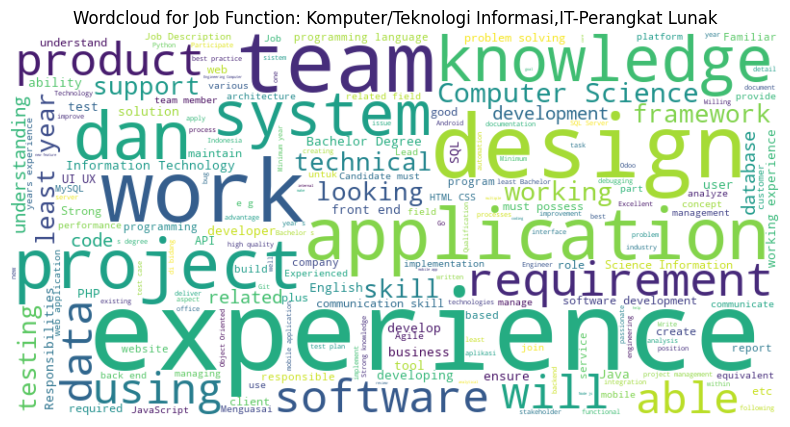

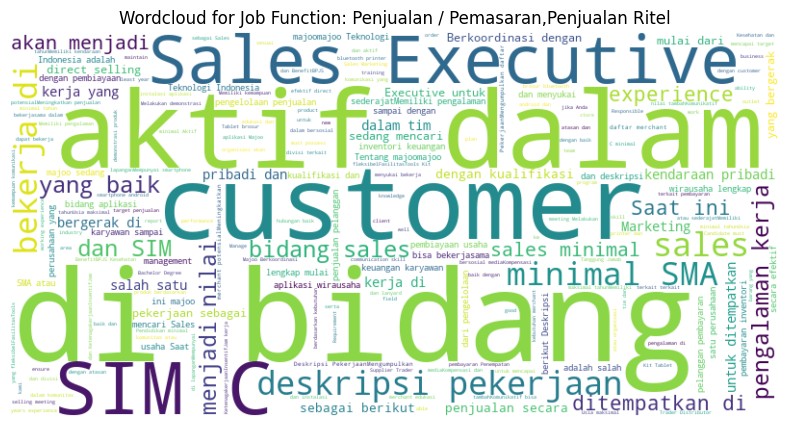

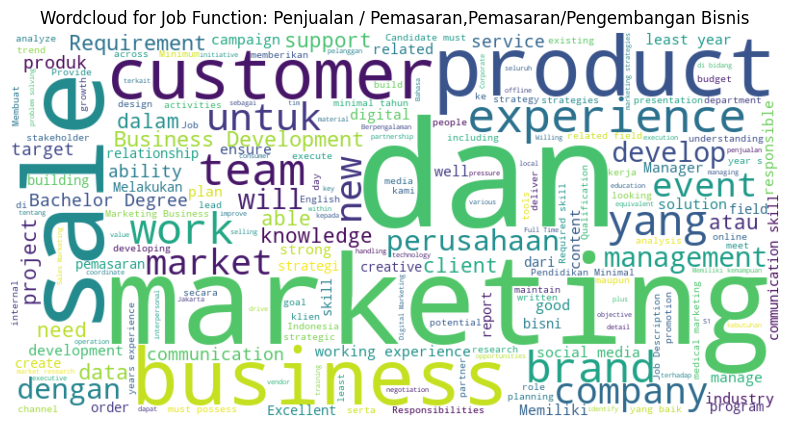

In [7]:
top_functions = final_df["job_function"].value_counts().head(3).index

for func in top_functions:
    text = " ".join(final_df[final_df["job_function"] == func]["job_description"].astype(str))

    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Wordcloud for Job Function: {func}")
    plt.show()

#### Network Graph — Co-occurring Skills

Kode ini menghasilkan semua pasangan skill yang muncul bersama dalam satu lowongan, lalu menghitung frekuensi kemunculannya menggunakan Counter.

In [8]:
pairs = []

for skills in final_df["skills"]:
    if len(skills) > 1:
        for i in range(len(skills)):
            for j in range(i+1, len(skills)):
                pairs.append(tuple(sorted((skills[i], skills[j]))))

pair_counts = Counter(pairs)

Kode ini membuat graph NetworkX dan menambahkan edge antar skill yang sering muncul bersama (hanya pasangan dengan frekuensi ≥ 30 agar graph tidak terlalu padat).

In [9]:
G = nx.Graph()

for (s1, s2), weight in pair_counts.items():
    if weight >= 35:  # threshold agar graph tidak terlalu penuh
        G.add_edge(s1, s2, weight=weight)

Kode ini mengubah graph NetworkX menjadi visualisasi interaktif menggunakan PyVis dan menyimpannya dalam file HTML.

In [10]:
# Buat visualisasi interaktif
net = Network(height="600px", width="100%", notebook=True)
net.from_nx(G)

# Simpan ke HTML
net.show("skill_network.html")

skill_network.html


## Pertanyaan 2

#### Industry vs Career Level

<Figure size 1400x700 with 0 Axes>

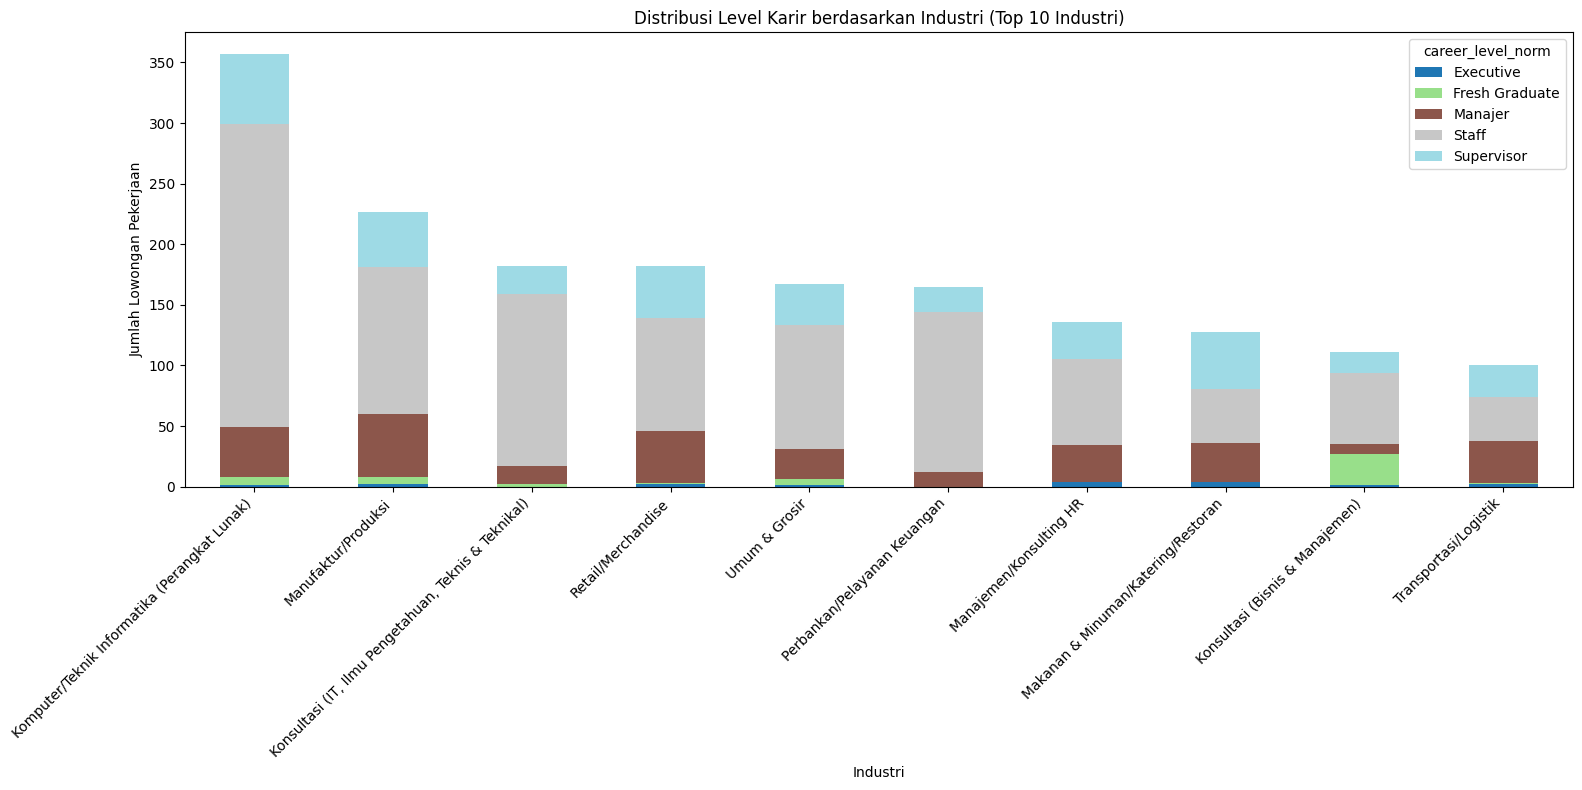

In [11]:
plt.figure(figsize=(14, 7))
career_industry = final_df.groupby(
    ["company_industry", "career_level_norm"]
).size().unstack(fill_value=0)
top10_industries = career_industry.sum(axis=1).sort_values(ascending=False).head(10).index
career_industry_top10 = career_industry.loc[top10_industries]
career_industry_top10.plot(
    kind="bar",
    stacked=True,
    figsize=(16, 8),
    colormap="tab20"
)

plt.title("Distribusi Level Karir berdasarkan Industri (Top 10 Industri)")
plt.xlabel("Industri")
plt.ylabel("Jumlah Lowongan Pekerjaan")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Berdasarkan distribusi level karier pada sepuluh industri dengan jumlah lowongan terbanyak, terlihat bahwa hampir semua industri didominasi oleh lowongan pada level `Staff`, terutama pada sektor `Komputer/Teknik Informatika`, `Manufaktur`, dan `Konsultasi`. Hal ini menunjukkan bahwa pasar tenaga kerja lebih banyak membutuhkan peran operasional dan eksekusi, sehingga peluang terbesar tersedia bagi kandidat dengan pengalaman awal hingga menengah.

Lowongan pada level `Manager` dan `Supervisor` jumlahnya lebih terbatas namun konsisten, dengan proporsi yang relatif lebih tinggi pada industri `Retail`, `Manajemen/Konsulting HR`, serta `Makanan & Minuman`. Sementara itu, lowongan `Fresh Graduate` cenderung lebih sedikit di hampir semua industri, menandakan bahwa perusahaan lebih memprioritaskan kandidat yang telah memiliki pengalaman atau keterampilan siap kerja. Posisi `Executive` menjadi level dengan jumlah lowongan paling minim, yang mengindikasikan bahwa peran strategis umumnya diisi melalui promosi internal atau rekrutmen khusus.

#### Industry vs Education Level

/var/folders/2x/6ysp6yr56c3017xsg0jb_l480000gn/T/ipykernel_89648/1084561618.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top["company_industry"] = pd.Categorical(


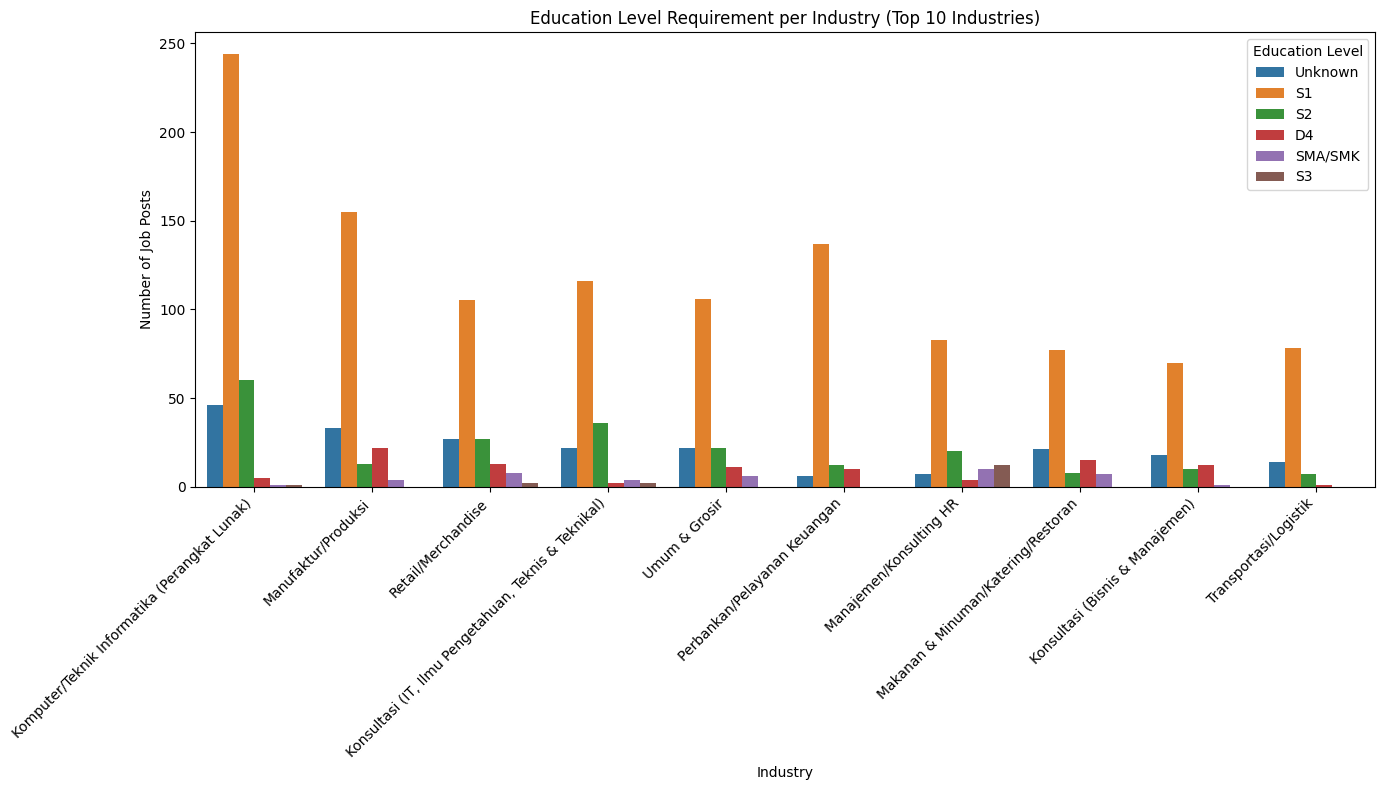

In [12]:
# Ambil top 10 industri berdasarkan jumlah lowongan (descending)
top_ind = final_df["company_industry"].value_counts().sort_values(ascending=False).head(10).index
df_top = final_df[final_df["company_industry"].isin(top_ind)]
df_top["company_industry"] = pd.Categorical(
    df_top["company_industry"],
    categories=top_ind,
    ordered=True
)

plt.figure(figsize=(14, 8))
sns.countplot(
    data=df_top,
    x="company_industry",
    hue="education_level_norm",
    order=top_ind
)

plt.title("Education Level Requirement per Industry (Top 10 Industries)")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Industry")
plt.ylabel("Number of Job Posts")
plt.legend(title="Education Level")
plt.tight_layout()
plt.show()

Visualisasi menunjukkan bahwa pendidikan `S1` menjadi persyaratan yang paling dominan di hampir semua industri, terutama pada sektor `Komputer/Teknik Informatika`, `Manufaktur`, `Perbankan/Pelayanan Keuangan`, dan `Konsultasi`. Hal ini mengindikasikan bahwa gelar sarjana masih menjadi standar utama dalam proses rekrutmen, khususnya untuk peran professional dan operasional menengah.

Persyaratan `S2` dan `S3` relatif jauh lebih sedikit dan umumnya muncul pada industri berbasis pengetahuan seperti `IT`, `Konsultasi Teknis`, dan `Keuangan`, yang menunjukkan bahwa pendidikan lanjutan dibutuhkan untuk peran yang lebih spesialis atau strategis. Sementara itu, industri `Retail`, `Makanan & Minuman`, serta `Transportasi/Logistik` menunjukkan proporsi yang lebih besar untuk pendidikan `D4` dan `SMA/SMK`, mencerminkan kebutuhan tenaga kerja operasional dan praktis.

Selain itu, masih terdapat sejumlah lowongan dengan tingkat pendidikan `tidak disebutkan (Unknown)`, terutama pada industri dengan volume rekrutmen tinggi, yang mengindikasikan fleksibilitas persyaratan pendidikan atau kurangnya standarisasi dalam penulisan lowongan.

#### Experience Years per Industry

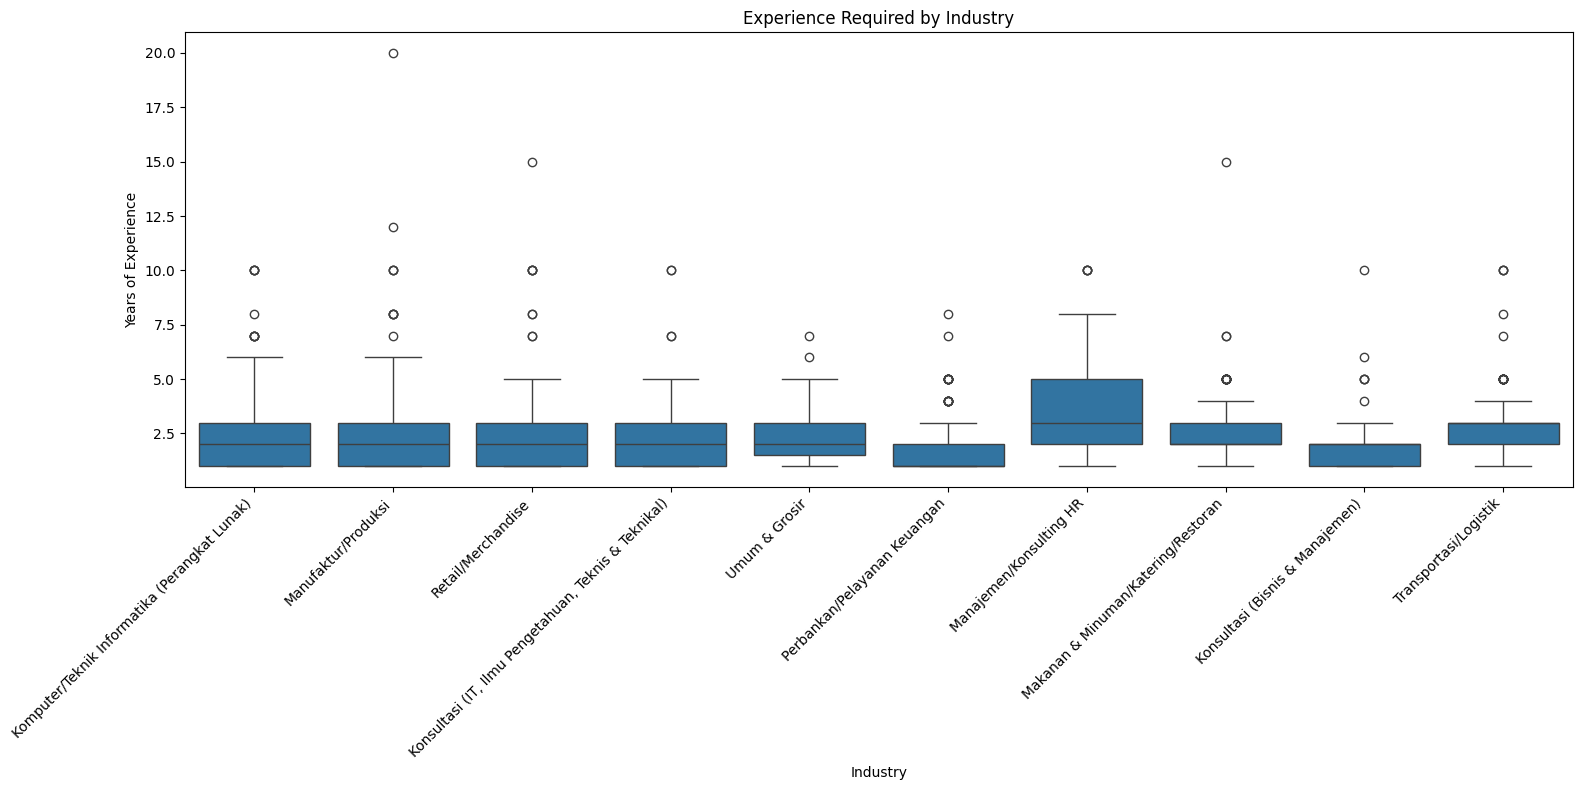

In [13]:
plt.figure(figsize=(16, 8))
sns.boxplot(
    data=df_top,
    x="company_industry",
    y="experience_years"
)

plt.title("Experience Required by Industry")
plt.xlabel("Industry")
plt.ylabel("Years of Experience")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Visualisasi boxplot menunjukkan bahwa sebagian industri mensyaratkan pengalaman kerja sekitar 1-3 tahun, yang tercermin dari nilai median yang relatif seragam di hampir semua industri. Hal ini mengindikasikan bahwa pasar lowongan kerja didominasi oleh posisi junior hingga menengah, bukan untuk kandidat tanpa pengalaman maupun level senior.

Industri `Manajemen/Konsulting HR` memiliki median pengalaman yang paling tinggi serta sebaran yang lebih lebar, menandakan kebutuhan kandidat dengan pengalaman yang lebih matang dan beragam, terutama untuk peran supervisi dan manajerial. Sebaliknya, industri `Perbankan/Pelayanan Keuangan`, `Konsultasi (Bisnis & Manajemen)`, serta `Komputer/Teknik Informatika` cenderung mensyaratkan pengalaman yang lebih rendah dan lebih homogen, sehingga relatif lebih terbuka bagi kandidat dengan pengalaman awal.

Keberadaan outlier dengan kebutuhan pengalaman tinggi (hingga 10-20 tahun) di beberapa industri menunjukkan adanya lowongan untuk posisi senior atau spesialis, meskipun jumlahnya terbatas.

#### Heatmap Career Level

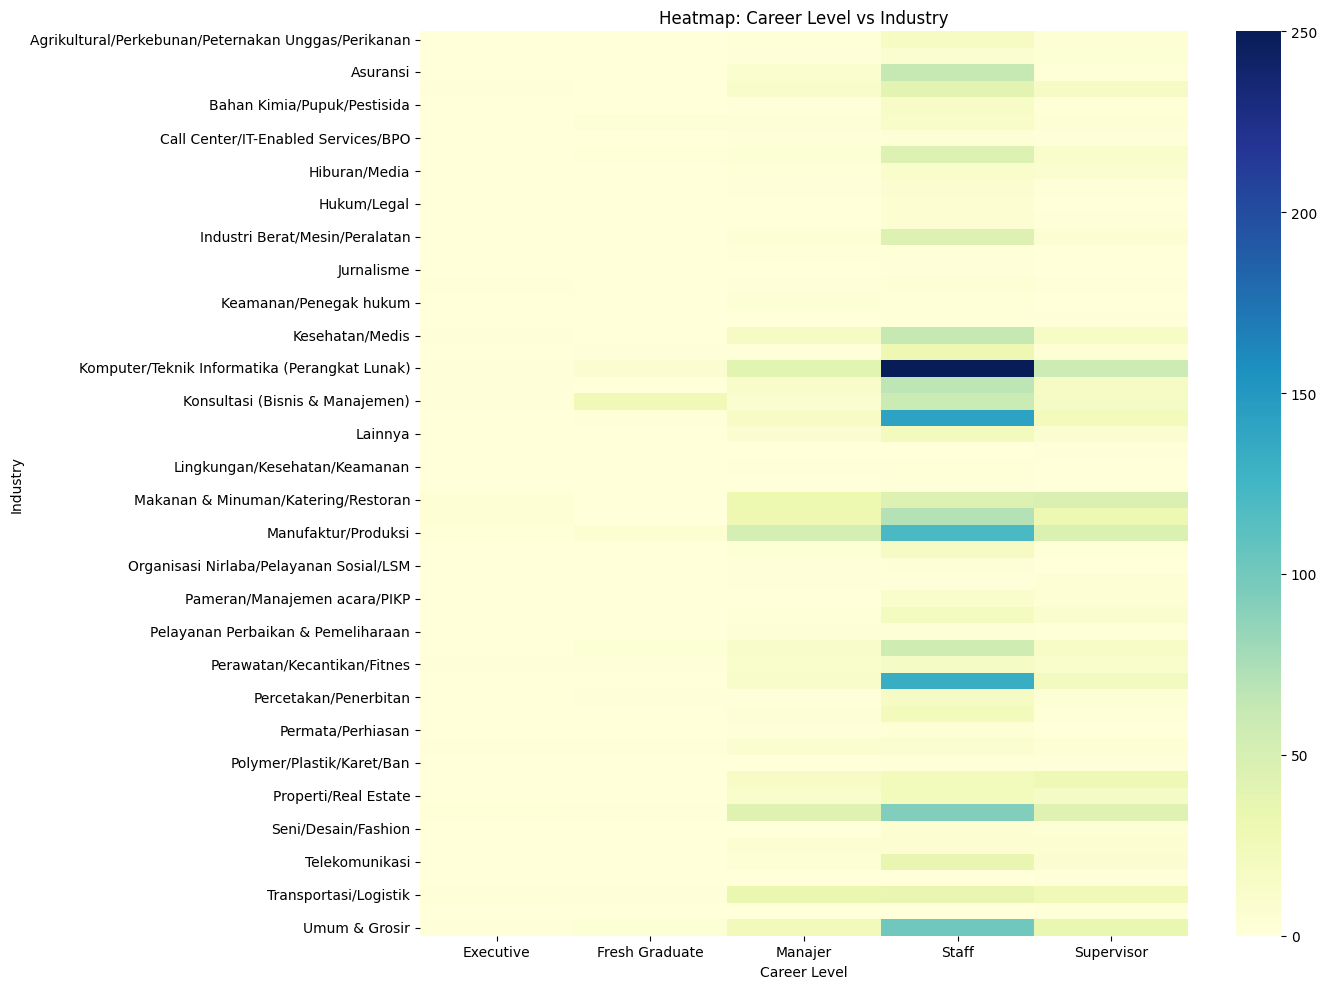

In [14]:
heatmap_career = final_df.pivot_table(
    index="company_industry",
    columns="career_level_norm",
    aggfunc="size",
    fill_value=0
)

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_career, cmap="YlGnBu", annot=False)
plt.title("Heatmap: Career Level vs Industry")
plt.xlabel("Career Level")
plt.ylabel("Industry")
plt.tight_layout()
plt.show()

Heatmap menunjukkan bahwa lowongan kerja di hampir seluruh industri didominasi oleh level `Staff`, dengan intensitas tertinggi pada industri `Komputer/Teknik Informatika (Perangkat Lunak)`, `Manufaktur/Produksi`, `Konsultasi (Bisnis & Manajemen)`, serta `Umum & Grosir`. Hal ini menegaskan bahwa kebutuhan tenaga kerja paling besar berada pada peran operasional dan eksekusi.

#### Heatmap Education Level

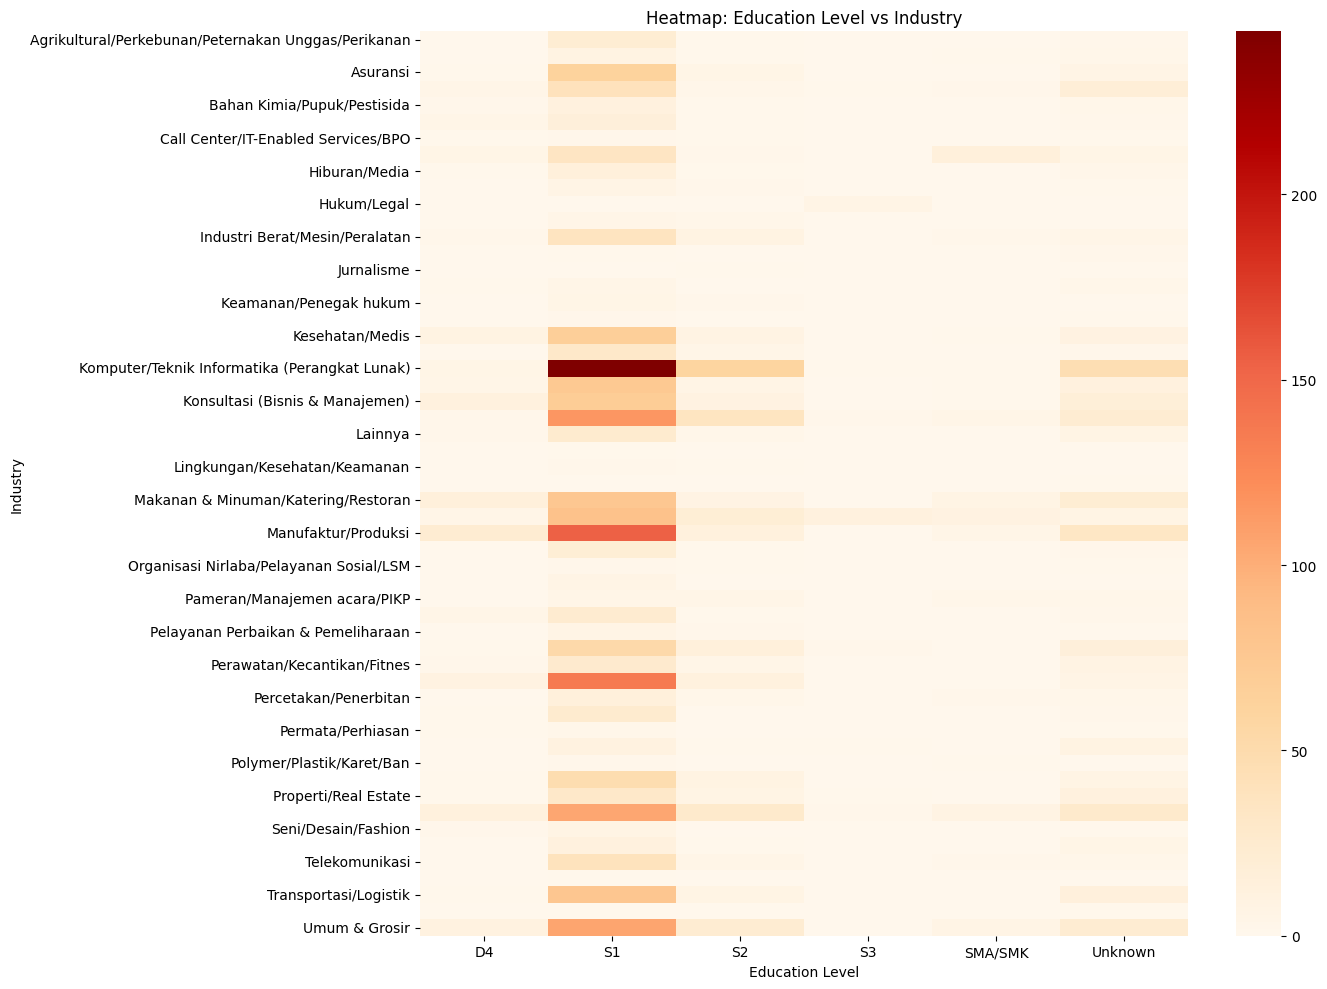

In [15]:
heatmap_edu = final_df.pivot_table(
    index="company_industry",
    columns="education_level_norm",
    aggfunc="size",
    fill_value=0
)

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_edu, cmap="OrRd", annot=False)
plt.title("Heatmap: Education Level vs Industry")
plt.xlabel("Education Level")
plt.ylabel("Industry")
plt.tight_layout()
plt.show()

Heatmap menunjukkan bahwa pendidikan S1 mendominasi persyaratan lowongan di hampir seluruh industri, dengan intensitas tertinggi pada sektor `Komputer/Teknik Informatika (Perangkat Lunak)`, `Manufaktur/Produksi`, `Konsultasi (Bisnis & Manajemen)`, serta `Umum & Grosir`. Hal ini menegaskan bahwa gelar sarjana menjadi standar utama rekrutmen lintas industri.

#### Heatmap Experience Bucket

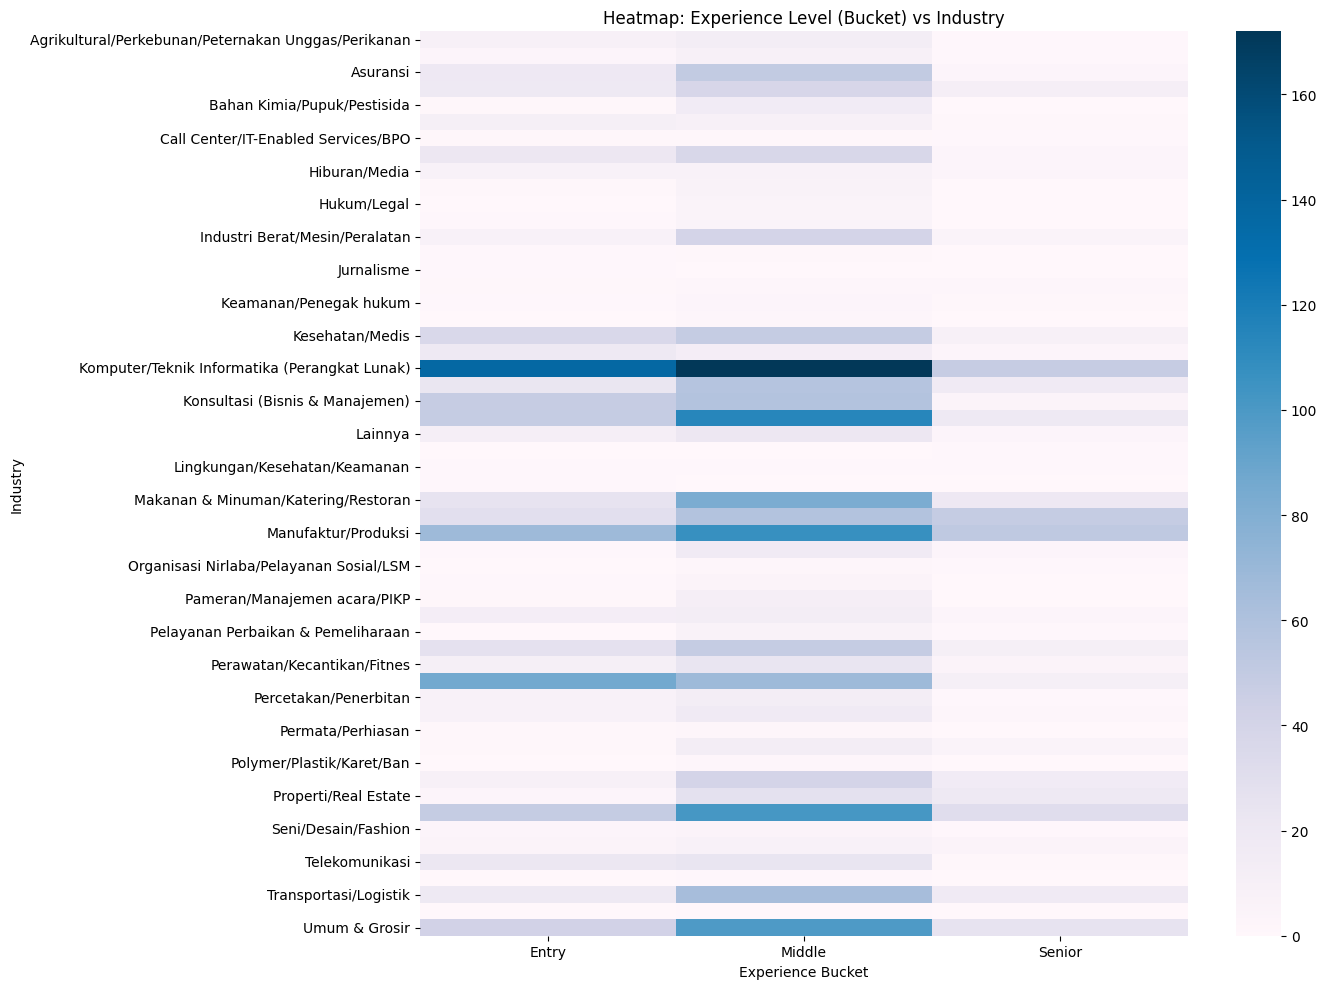

In [16]:
heatmap_exp = final_df.pivot_table(
    index="company_industry",
    columns="experience_bucket",
    aggfunc="size",
    fill_value=0
)

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_exp, cmap="PuBu", annot=False)
plt.title("Heatmap: Experience Level (Bucket) vs Industry")
plt.xlabel("Experience Bucket")
plt.ylabel("Industry")
plt.tight_layout()
plt.show()

- **Dominasi Entry & Middle Level**  
  Mayoritas lowongan berada pada level *entry* dan *middle*, menunjukkan kebutuhan tinggi akan talenta awal–menengah. Posisi *senior* relatif terbatas dan bersifat strategis.

- **Industri dengan Peluang Entry–Middle Terbesar**  
  Industri **Komputer/Teknik Informatika, Manufaktur/Produksi, Konsultasi, Seni/Desain/Fashion, serta Umum & Grosir** paling aktif merekrut, cocok bagi kandidat dengan pendidikan **SMA–S1** dan skill yang dapat dikembangkan.

- **Karakteristik Senior Level**  
  Lowongan *senior* muncul lebih sedikit dan terpusat di industri tertentu (IT, Manufaktur, Konsultasi), menandakan kebutuhan akan pengalaman panjang, spesialisasi, dan kemampuan kepemimpinan.

# Conclusion

1. Berdasarkan analisis `job_description`, soft skills mendominasi permintaan pasar secara keseluruhan, memberikan indikasi bahwa dataset lowongan pekerjaan cenderung diisi oleh sektor non-teknologi atau posisi umum/operasional. Skill yang paling sering muncul dan bersifat dominan adalah `sales`, yang menunjukkan tingginya lowongan yang berorientasi pada aktivitas penjualan atau posisi komersial. Selain itu, kemampuan bahasa `english` muncul sebagai syarat umum yang banyak dicari di berbagai sektor, sementara skill manajerial seperti `management`, `manager`, dan `leadership` juga menunjukkan permintaan tinggi untuk peran yang membutuhkan pengelolaan pekerjaan atau kepemimpinan tim. Di sisi lain, fungsi pekerjaan teknis seperti Komputer/Teknologi Informasi, IT-Perangkat Lunak, menunjukkan fokus pada aspek teknis seperti `system`, `application`, `software`, `project`, dan `design`.

2. Karakteristik lowongan kerja di berbagai industri menunjukkan dominasi yang jelas pada posisi `Staff`, yang hampir terjadi di semua industri, menegaskan bahwa kebutuhan terbesar ada pada peran operasional dan eksekusi, dengan intensitas tertinggi di sektor Komputer/Teknik Informatika dan Manufaktur/Produksi. Secara simultan, mayoritas lowongan mensyaratkan tingkat pendidikan `Sarjana (S1)`, yang menjadikannya standar utama dalam proses rekrutmen untuk peran professional dan operasional menengah di hampir semua industri. Terkait pengalaman, pasar didominasi oleh kebutuhan akan kandidat `Entry` hingga `Middle` level (sekitar 1-4 tahun pengalaman), yang tercermin dari nilai median pengalaman kerja yang relatif seragam di kisaran 1-3 tahun di hampir semua industri, menunjukkan bahwa perusahaan cenderung memprioritaskan kandidat dengan keterampilan siap kerja awal hingga menengah. Posisi `Fresh Graduate` dan `Executive` memiliki jumlah lowongan paling minim.